# Real world example: Full EDGAR walkthrough

**Author:** Ties de Kok ([Personal Website](http://www.tiesdekok.com))  
**Last updated:** 7 July 2018  
**Python version:** Python 3.6  
**License:** MIT License  

## *Introduction*

A usual project that involves EDGAR data consists of 5 steps:

1. Determine URLs   
2. Download   
3. Prepare   
4. Extract relevant sections    
5. Perform textual analysis to generate metrics    

## *Demonstration*

Our goal for today is to perform a "real" task where we combine everything that we learned in the previous 4 sessions.  

### Task: 

> Generate some NLP metrics for the MD&A sections of 10-K filings by TESLA.   

Identifiers for Tesla:  
* **CIK:** `0001318605`   
* **GVKEY:** `184996`     

Link to EDGAR page:  
https://www.sec.gov/cgi-bin/browse-edgar?CIK=0001318605&action=getcompany



### *Relevant notebooks*

1. [`0_python_basics.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/0_python_basics.ipynb)
1. [`1_opening_files.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/0_python_basics.ipynb)
1. [`2_handling data.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/0_python_basics.ipynb)
1. [`3_web_scraping.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/0_python_basics.ipynb)
1. [`4_NLP_notebook.ipynb`](https://nbviewer.jupyter.org/github/TiesdeKok/LearnPythonforResearch/blob/master/0_python_basics.ipynb)

## Step 0: preamble <br> ------------------------

## Imports

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
## Standard
import os, re, sys, time

## Data handling
import pandas as pd
import numpy as np

## "Web scraping" and HTML
import requests
import lxml.html

## Convenience functions
from os.path import join
from tqdm import tqdm_notebook as tqdm

## NLP (Spacy)
import en_core_web_sm
nlp = en_core_web_sm.load()

#### Packages not installed in `uw-python-camp` environment

In [3]:
import unidecode
import wrds

Install these packages by opening up the Anaconda command line (terminal) and running:   
```
activate uw-python-camp
pip install unidecode
pip install wrds
```

**Note:** you will need to use `source active uw-python-camp` if on Mac OS or Linux

## Step 1: get URL to EDGAR filings <br> -----------------------------------------------

Before we can download our EDGAR filings we first need to:

1. Identify the filings that we are interested in  
2. Collect the URLs that we can use to download these filings  

We can do this in three ways:  

1. Use WRDS SEC Analytics Suite   
2. Download index files  
3. Scrape EDGAR directly   

**We will use WRDS SEC Analyics Suite (because we can)**

### 1) Get all 10-K filings using the WRDS SEC Analytics Suite   

### Approach 1: use the WRDS website   
> WRDS SEC Analytics Suite --> WRDS SEC Filings Index Data   

(Data already downloaded in `data/tesla_10-k_data.dta`)

In [4]:
tesla_10k_df = pd.read_stata(join('data', 'tesla_10-k_data.dta'))
tesla_10k_df[['cik', 'fdate', 'form', 'fname', 'iname']]

,cik,fdate,form,fname,iname
0,0001318605,2011-03-03,10-K,edgar/data/1318605/0001193125-11-054847.txt,edgar/data/1318605/0001193125-11-054847-index.htm
1,0001318605,2012-02-27,10-K,edgar/data/1318605/0001193125-12-081990.txt,edgar/data/1318605/0001193125-12-081990-index.htm
2,0001318605,2013-03-07,10-K,edgar/data/1318605/0001193125-13-096241.txt,edgar/data/1318605/0001193125-13-096241-index.htm
3,0001318605,2014-02-26,10-K,edgar/data/1318605/0001193125-14-069681.txt,edgar/data/1318605/0001193125-14-069681-index.htm
4,0001318605,2015-02-26,10-K,edgar/data/1318605/0001564590-15-001031.txt,edgar/data/1318605/0001564590-15-001031-index.htm
5,0001318605,2016-02-24,10-K,edgar/data/1318605/0001564590-16-013195.txt,edgar/data/1318605/0001564590-16-013195-index.htm
6,0001318605,2017-03-01,10-K,edgar/data/1318605/0001564590-17-003118.txt,edgar/data/1318605/0001564590-17-003118-index.htm
7,0001318605,2018-02-23,10-K,edgar/data/1318605/0001564590-18-002956.txt,edgar/data/1318605/0001564590-18-002956-index.htm


### Approach 2: use the `WRDS` Python package   
For an introduction to this approach see my ARC blog post:   
https://arc.eaa-online.org/blog/retrieving-data-wrds-directly-using-python-r-and-stata

In [6]:
db = wrds.Connection()

Enter your WRDS username [kokti]:tcjkok
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [7]:
cik_tesla = '0001318605'

sql_query = """
SELECT gvkey,
       cik,
       fdate,
       form,
       fname,
       iname
FROM wrdssec.forms 
WHERE form = '10-K' 
AND fdate >= '01-01-2009'
AND cik = '{}'
""".format(cik_tesla)

In [8]:
print(sql_query)


SELECT gvkey,
       cik,
       fdate,
       form,
       fname,
       iname
FROM wrdssec.forms 
WHERE form = '10-K' 
AND fdate >= '01-01-2009'
AND cik = '0001318605'



In [9]:
tesla_10k_df = db.raw_sql(sql_query)
tesla_10k_df

,gvkey,cik,fdate,form,fname,iname
0,184996,0001318605,2011-03-03,10-K,edgar/data/1318605/0001193125-11-054847.txt,edgar/data/1318605/0001193125-11-054847-index.htm
1,184996,0001318605,2012-02-27,10-K,edgar/data/1318605/0001193125-12-081990.txt,edgar/data/1318605/0001193125-12-081990-index.htm
2,184996,0001318605,2013-03-07,10-K,edgar/data/1318605/0001193125-13-096241.txt,edgar/data/1318605/0001193125-13-096241-index.htm
3,184996,0001318605,2014-02-26,10-K,edgar/data/1318605/0001193125-14-069681.txt,edgar/data/1318605/0001193125-14-069681-index.htm
4,184996,0001318605,2015-02-26,10-K,edgar/data/1318605/0001564590-15-001031.txt,edgar/data/1318605/0001564590-15-001031-index.htm
5,184996,0001318605,2016-02-24,10-K,edgar/data/1318605/0001564590-16-013195.txt,edgar/data/1318605/0001564590-16-013195-index.htm
6,184996,0001318605,2017-03-01,10-K,edgar/data/1318605/0001564590-17-003118.txt,edgar/data/1318605/0001564590-17-003118-index.htm
7,184996,0001318605,2018-02-23,10-K,edgar/data/1318605/0001564590-18-002956.txt,edgar/data/1318605/0001564590-18-002956-index.htm


## Step 2: download EDGAR filings <br> ----------------------------------------------

Each EDGAR filing consists of several documents. I recommend to download the aggregate TXT file called: `Complete submission text file`   

See for example: https://www.sec.gov/Archives/edgar/data/1318605/0001193125-11-054847-index.htm

### 2a) Understand EDGAR files and urls   
You need to add "https://www.sec.gov/Archives/" to create the full URL

In [10]:
edgar_url = "https://www.sec.gov/Archives/"

In [12]:
print(tesla_10k_df.iloc[0]['iname'])

edgar/data/1318605/0001193125-11-054847-index.htm


In [13]:
print(edgar_url + tesla_10k_df.iloc[0]['iname'])
print(edgar_url + tesla_10k_df.iloc[0]['fname'])

https://www.sec.gov/Archives/edgar/data/1318605/0001193125-11-054847-index.htm
https://www.sec.gov/Archives/edgar/data/1318605/0001193125-11-054847.txt


In [15]:
tesla_10k_df['download_url'] = tesla_10k_df.fname.apply(lambda file_url: edgar_url + file_url)

In [19]:
tesla_10k_df.iloc[0]['download_url']

'https://www.sec.gov/Archives/edgar/data/1318605/0001193125-11-054847.txt'

### 2b) Create basic downloader that can deal with failure

In [25]:
test_url = tesla_10k_df.iloc[0]['download_url']
test_url

'https://www.sec.gov/Archives/edgar/data/1318605/0001193125-11-054847.txt'

In [26]:
res = requests.get(test_url)
res.status_code

200

In [27]:
def download_file(url, max_tries=4, sleep_time = 1):
    failed_attempts = 0
    while True: 
        res = requests.get(url)
        
        if res.status_code == 200:
            return True, res.text
        else:
            if failed_attempts < max_tries:
                failed_attempts += 1
                time.sleep(sleep_time)
            else:
                return False, 'Could not download'

In [30]:
test_res = download_file(test_url)
print(test_res[0])

True


### 2c) Download all the fillings

Think carefully about the data structure! I usually recommend to use dictionaries for things that you want to keep associated with an identifier. 

In [40]:
filing_dict = {}
for url in tqdm(tesla_10k_df.download_url):
    res = download_file(url)
    if res[0] == True:
        filing_dict[url] = res[1]

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [48]:
len(tesla_10k_df)

8

In [50]:
tesla_10k_dict = {}
status_dict = {}
for index, row in tqdm(tesla_10k_df.iterrows(), total=len(tesla_10k_df.index)):
    download_res = download_file(row['download_url'])
    
    status_dict[index] = download_res[0]
    
    if download_res[0]:
        tesla_10k_dict[row['fname']] = download_res[1]

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [51]:
tesla_10k_df['download_status'] = pd.Series(status_dict)

In [52]:
tesla_10k_df.head(2)

,gvkey,cik,fdate,form,fname,iname,download_url,download_status
0,184996,0001318605,2011-03-03,10-K,edgar/data/1318605/0001193125-11-054847.txt,edgar/data/1318605/0001193125-11-054847-index.htm,https://www.sec.gov/Archives/edgar/data/131860...,True
1,184996,0001318605,2012-02-27,10-K,edgar/data/1318605/0001193125-12-081990.txt,edgar/data/1318605/0001193125-12-081990-index.htm,https://www.sec.gov/Archives/edgar/data/131860...,True


In [60]:
print(tesla_10k_dict['edgar/data/1318605/0001193125-11-054847.txt'][2000:3000])

x;margin-bottom:2px;border-bottom:1pt solid #000000;width:21%">&nbsp;</P></center> <P STYLE="margin-top:4px;margin-bottom:0px" ALIGN="center"><FONT STYLE="font-family:Times New Roman" SIZE="5"><B>FORM 10-K
</B></FONT></P> <P STYLE="margin-top:4px;margin-bottom:0px"><FONT STYLE="font-family:Times New Roman" SIZE="2">(Mark One) </FONT></P>
<TABLE STYLE="BORDER-COLLAPSE:COLLAPSE" BORDER="0" CELLPADDING="0" CELLSPACING="0" WIDTH="100%">
<TR>
<TD WIDTH="4%" VALIGN="top" ALIGN="left"><FONT STYLE="font-family:Times New Roman" SIZE="2"><B></B><FONT STYLE="FONT-FAMILY:WINGDINGS">&#120;</FONT><B></B><B></B></FONT></TD>
<TD ALIGN="left" VALIGN="top"><FONT STYLE="font-family:Times New Roman" SIZE="2"><B>ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 </B></FONT></TD></TR></TABLE>
<P STYLE="margin-top:0px;margin-bottom:0px; text-indent:4%"><FONT STYLE="font-family:Times New Roman" SIZE="2"><B>For the fiscal year ended December&nbsp;31, 2010 </B></FONT></P> <P ST

## Step 3: prepare EDGAR filing <br> -----------------------------------------

Before we can start working with the EDGAR filings we need to process the file we retrieved, in this case: 
1. Split the documents up  
2. Keep the 10-K document
3. Parse raw text into HTML + extract text   
4. Clean the text up

### 3a) Create a test document save it for manual inspection

In [61]:
test_doc = tesla_10k_dict['edgar/data/1318605/0001193125-11-054847.txt']

In [62]:
with open('test_doc.txt', 'w') as f:
    f.write(test_doc)

### 3b) Create logic to split the documents up

How do we do this? Regular Expressions! 

#### Define regular expressions

In [63]:
pattern_dict = {
    'documents' : re.compile(r"<document>(.*?)</document>", re.IGNORECASE | re.DOTALL),
    'metadata' : {
        'type' : re.compile(r"<type>(.*?)\n", re.IGNORECASE | re.DOTALL),
        'sequence' : re.compile(r"<sequence>(.*?)\n", re.IGNORECASE | re.DOTALL),
        'filename' : re.compile(r"<filename>(.*?)\n", re.IGNORECASE | re.DOTALL),
        'description' : re.compile(r"<description>(.*?)\n", re.IGNORECASE | re.DOTALL)
    },
    'text' : re.compile(r"<text>(.*?)</text>", re.IGNORECASE | re.DOTALL)
}

In [64]:
pattern_dict['metadata']['filename'].findall(test_doc)

['d10k.htm',
 'dex1047.htm',
 'dex211.htm',
 'dex231.htm',
 'dex311.htm',
 'dex312.htm',
 'dex321.htm',
 'g151489g81s77.jpg']

#### *Alternative: use `LXML` to parse the SGML structure*

In [65]:
sgml_parsed = lxml.html.fromstring(test_doc)

In [66]:
for document in sgml_parsed.cssselect('document'):
    print(document.cssselect('filename')[0].text.strip())

d10k.htm
dex1047.htm
dex211.htm
dex231.htm
dex311.htm
dex312.htm
dex321.htm
g151489g81s77.jpg


#### Split up into documents

In [67]:
docs_split = pattern_dict['documents'].findall(test_doc)
print(len(docs_split))

8


#### Create function to extract information from one document

In [71]:
def extract_metadata(doc, pattern_dict=pattern_dict):
    data_dict = {}
    
    data_dict['metadata'] = {}
    for key, pattern in pattern_dict['metadata'].items():
        matches = pattern.findall(doc)
        if matches:
            data_dict['metadata'][key] = matches[0]
        else:
            data_dict['metadata'][key] = np.nan
            
    text_match = pattern_dict['text'].findall(doc)
    if text_match:
        data_dict['text'] = text_match[0]
    else:
        data_dict['text'] = np.nan
        
    return data_dict

In [72]:
test = extract_metadata(docs_split[0])

In [73]:
test.keys()

dict_keys(['metadata', 'text'])

In [74]:
test['metadata']

{'description': 'FOR THE FISCAL YEAR ENDED DECEMBER 31, 2010',
 'filename': 'd10k.htm',
 'sequence': '1',
 'type': '10-K'}

### Apply extraction function to all filings to retrieve the 10-K part

In [75]:
data_10k_dict = {}
for filename, data in tqdm(tesla_10k_dict.items()):
    docs_split = pattern_dict['documents'].findall(data)
        
    for doc in docs_split:
        doc_data = extract_metadata(doc)
        
        ## Only keep 10-K document
        if doc_data['metadata']['type'] == '10-K':
            data_10k_dict[filename] = doc_data['text']
            break

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [76]:
len(data_10k_dict)

8

In [77]:
print(data_10k_dict['edgar/data/1318605/0001193125-11-054847.txt'][:1000])


<HTML><HEAD>
<TITLE>For the fiscal year ended December 31, 2010</TITLE>
</HEAD>
 <BODY BGCOLOR="WHITE">
<h5 align="left"><a href="#toc">Table of Contents</a></h5>

 <P STYLE="line-height:0px;margin-top:0px;margin-bottom:0px;border-bottom:0.5pt solid #000000">&nbsp;</P>
<P STYLE="line-height:3px;margin-top:0px;margin-bottom:2px;border-bottom:0.5pt solid #000000">&nbsp;</P> <P STYLE="margin-top:4px;margin-bottom:0px" ALIGN="center"><FONT STYLE="font-family:Times New Roman" SIZE="5"><B>UNITED STATES </B></FONT></P>
<P STYLE="margin-top:0px;margin-bottom:0px" ALIGN="center"><FONT STYLE="font-family:Times New Roman" SIZE="5"><B>SECURITIES AND EXCHANGE COMMISSION </B></FONT></P> <P STYLE="margin-top:0px;margin-bottom:0px" ALIGN="center"><FONT
STYLE="font-family:Times New Roman" SIZE="2"><B>Washington, D.C. 20549 </B></FONT></P> <P STYLE="font-size:4px;margin-top:0px;margin-bottom:0px">&nbsp;</P><center>
<P STYLE="line-height:6px;margin-top:0px;margin-bottom:2px;border-bottom:1pt solid #0000

### 3c) Parse raw 10-K data as HTML

If we are only interested in the text we can use `.text_content()` on the html object to extract only the text

In [78]:
test = lxml.html.fromstring(data_10k_dict['edgar/data/1318605/0001193125-11-054847.txt'])

#test.cssselect('TITLE')[0].text_content()

In [80]:
test_2 = test.text_content()

In [84]:
html_10k_dict = {}
text_10k_dict = {}
for filename, raw_text in tqdm(data_10k_dict.items()):
    html = lxml.html.fromstring(raw_text)
    html_10k_dict[filename] = html
    text_10k_dict[filename] = html.text_content()

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [87]:
text_10k_dict['edgar/data/1318605/0001193125-11-054847.txt'][20000:21000]

' gallon city and 25 miles per gallon highway. Furthermore, we expect our electric vehicles will have lower relative\n\n \xa0 5 \n\n\n\n\nTable of Contents\n\n\n\n\n\xa0\n \nmaintenance costs than hybrid, plug-in hybrid, or internal combustion engine vehicles due to fewer moving parts and the absence of certain components, including oil, oil filters, spark plugs and\nengine valves. Additionally, government incentives that are currently available can reduce the cost of ownership even further.  \xa0\n\n\n\xa0\n\x95\n\xa0\n High-Performance Without Compromised Design or Functionality. We believe we have been able to successfully overcome the design and performance\ntradeoff issues that encumbered most early electric vehicle designs. We believe the Tesla Roadster delivers an unparalleled driving experience with instantaneous and sustained acceleration through an extended range of speed. In addition, our planned\nModel\xa0S is being designed to seat five adults, provide best in class storag

### 3d) Clean up the text   
I usually do at least two things:  

1. I try to fix encoding errors to avoid getting too many weird characters  
2. Replace newline characters with a whitespace
3. Remove as many unnescessary whitespaces as possible   
4. Remove "table of contents" text and page number

In [99]:
cleantext_10k_dict = {}
for filename, text in tqdm(text_10k_dict.items()):
    ## Fix encoding
    clean_text = unidecode.unidecode(text)
    
    ## Replace newline characters with space
    clean_text = re.sub('\s', ' ', clean_text)
    
    ## Remove duplicate whitespaces
    clean_text = ' '.join([word for word in clean_text.split(' ') if word != ''])
    
    ## Replace "Page number + Table of Contents footer"
    clean_text = re.sub(' \d+ Table of Contents ', ' ', clean_text)
    
    cleantext_10k_dict[filename] = clean_text

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [100]:
cleantext_10k_dict['edgar/data/1318605/0001193125-11-054847.txt'][19000:21000]

'nformation Administration of the U.S. Department of Energy, the cost per mile to fuel the Tesla Roadster is approximately 70% less than the cost to fuel the 2009 Porsche 911 Carrera, which has an EPA mileage rating of 18 miles per gallon city and 25 miles per gallon highway. Furthermore, we expect our electric vehicles will have lower relative maintenance costs than hybrid, plug-in hybrid, or internal combustion engine vehicles due to fewer moving parts and the absence of certain components, including oil, oil filters, spark plugs and engine valves. Additionally, government incentives that are currently available can reduce the cost of ownership even further. High-Performance Without Compromised Design or Functionality. We believe we have been able to successfully overcome the design and performance tradeoff issues that encumbered most early electric vehicle designs. We believe the Tesla Roadster delivers an unparalleled driving experience with instantaneous and sustained acceleration

## Step 4: extract section <br> --------------------------------

### 4a) Create a function that can extract the MD&A part

The MD&A section starts with something along the lines of:

> Item 7, Management's Discussion and Analysis of Financial Condition and Results of Operations

And ends with the next section that starts with something along the lines of:

> Item 7A, Quantitative and Qualitative Disclosures About Market Risk; 

So the trick is to identify where the MD&A sections starts and where it ends, once we know that we can extract the MD&A part.


In [101]:
def extract_MDA_from_10K(text, section_number_range = 10, keyword_range = 200, 
                         reference_range = 10, title_range = 100, min_length = 1000):
    """Extract the MD&A part out of a 10-K filing. """
    
    ## Split the document based on the word "item"
    parts = re.split('item|Item|ITEM', text)
    
    # ------------------------------------------
    # Step 1: try to find where the MD&A begins
    # ------------------------------------------

    ## Loop over each part and check whether it starts with 7 that is not followed by an "a"
    valid_start_parts = []
    for i, text in enumerate(parts):
        if '7' in text.strip()[:section_number_range] and not '7a' in text.strip().lower()[:section_number_range]:
            valid_start_parts.append(i)
    
    # ----------------------------------------
    # Step 2: try to find where the MD&A ends
    # ----------------------------------------

    results = []
    reference = 0

    ## Loop over all elements that start with 7 (excluding those starting with 7a)
    for i in valid_start_parts:
        mda_text = parts[i]
        endPoint = i+1

        isValid = 0
        reference = 0

        ## Loop over the elements that follow the current element and check whether it matches item 7a
        while endPoint < len(parts):
            end_part_text = parts[endPoint]
            ## Check if potential candidate for ending part
            if '7a' in end_part_text.strip().lower()[:section_number_range]:
                
                ## Check for keywords (quan and qual) that indicate start section 7a (and not just 7a mentioned in the text)
                if end_part_text[:keyword_range].lower().find('quan') >= 0 and end_part_text[:keyword_range].lower().find('qual') >= 0:
                    
                    ## Final check to make sure it is not a reference, if not then consider valid and break loop
                    if mda_text[-reference_range:].lower().find(' see ') <= 0 and mda_text[-reference_range:].lower().find(' in ') <= 0:
                        isValid = 1
                        break
            
            ## If not the end then add the part of the text but keep searching by going to the next one
            mda_text = ' '.join((mda_text, parts[endPoint]))
            endPoint += 1
            
        # ----------------------------------------
        # Step 3: double check it is a valid text
        # ----------------------------------------
        
        ## Short hits are either invalid or imply incorporated by reference
        if (len(mda_text) < min_length):
            if mda_text.lower().find('incorporated') and mda_text.lower().find('reference'):
                reference = 1
            else:
                isValid = 0

        ## Check whether it contains the title, otherwise consider it an invalid hit
        if mda_text[:title_range].lower().find('discussion') < 0 and mda_text[:title_range].lower().find('analysis') < 0:
            isValid = 0

        ## Append valid hits that do not indicate incorporated by reference
        if isValid:
            if not reference:
                results.append(mda_text)

    ## Return the shortest possible valid mda_text:
    if len(results) > 0:
        return {'status' : 'Good', 
                'mda_text' : sorted(results, key = len)[0]}
    else:
        if reference:
            return {'status' : 'Reference', 
                    'mda_text' : None}
        else:
            return {'status' : 'Not found', 
                    'mda_text' : None}

### 4b) Apply MD&A function on the text of each 10-K filing 

In [102]:
mda_text_dict = {}
mda_status_list = []
for filename, text in tqdm(cleantext_10k_dict.items()):
    mda_result = extract_MDA_from_10K(text)
    
    mda_status_list.append([filename, mda_result['status']])
    
    if mda_result['status'] == 'Good':
        mda_text_dict[filename] = mda_result['mda_text']

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [103]:
pd.DataFrame(mda_status_list, columns=['filename', 'status'])

,filename,status
0,edgar/data/1318605/0001193125-11-054847.txt,Good
1,edgar/data/1318605/0001193125-12-081990.txt,Good
2,edgar/data/1318605/0001193125-13-096241.txt,Good
3,edgar/data/1318605/0001193125-14-069681.txt,Good
4,edgar/data/1318605/0001564590-15-001031.txt,Good
5,edgar/data/1318605/0001564590-16-013195.txt,Good
6,edgar/data/1318605/0001564590-17-003118.txt,Good
7,edgar/data/1318605/0001564590-18-002956.txt,Good


In [104]:
mda_text_dict['edgar/data/1318605/0001193125-11-054847.txt'][:3000]

' 7. MANAGEMENTS DISCUSSION AND ANALYSIS OF FINANCIAL CONDITION AND RESULTS OF OPERATIONS The following discussion and analysis should be read in conjunction with our consolidated financial statements and the related notes that appear elsewhere in this Annual Report on Form 10-K. These discussions contain forward-looking statements reflecting our current expectations that involve risks and uncertainties. These forward-looking statements include, but are not limited to, statements concerning our strategy, future operations, future financial position, future revenues, projected costs, expectations regarding demand and acceptance for our technologies, growth opportunities and trends in the market in which we operate, prospects and plans and objectives of management. The words anticipates, believes, estimates, expects, intends, may, plans, projects, will, would and similar expressions are intended to identify forward-looking statements, although not all forward-looking statements contain t

In [41]:
mda_text_dict['edgar/data/1318605/0001193125-11-054847.txt'][-3000:]

'etermine with certainty the potential costs to remediate any pre-existing contamination. Based on managements best estimate, we estimated the fair value of the environmental liabilities that we assumed to be $5.3 million, which is not reflected in the table above as the timing of any potential payments cannot be reasonably determined at this time. As NUMMI continues with its decommissioning activities and as we continue with our planned construction and operating activities, it is reasonably possible that our estimate of environmental liabilities may change materially. We have reached an agreement with NUMMI under which, over a ten year period, we will pay the first $15.0 million of any costs of any governmentally-required remediation activities for contamination that existed prior to the completion of the facility and land purchase for any known or unknown environmental conditions, and NUMMI has agreed to pay the next $15.0 million for such remediation activities. Our agreement provi

## Step 5: calculate metrics <br> ------------------------------------

### 5a) Use spacy to split text up into sentence and words

Parse each text using Spacy

In [105]:
spacy_mda_dict = {}
for filename, mda_text in tqdm(mda_text_dict.items()):
    spacy_mda_dict[filename] = nlp(mda_text)

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

Split up into sentences and tokens

In [106]:
mda_sen_and_token_dict = {}
for filename, spacy_obj in tqdm(spacy_mda_dict.items()):
    sentences = []
    for sentence in spacy_obj.sents:
        sentences.append([token.text.lower() for token in sentence])
    mda_sen_and_token_dict[filename] = sentences

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [107]:
mda_sen_and_token_dict['edgar/data/1318605/0001193125-11-054847.txt'][2]

['the',
 'following',
 'discussion',
 'and',
 'analysis',
 'should',
 'be',
 'read',
 'in',
 'conjunction',
 'with',
 'our',
 'consolidated',
 'financial',
 'statements',
 'and',
 'the',
 'related',
 'notes',
 'that',
 'appear',
 'elsewhere',
 'in',
 'this',
 'annual',
 'report',
 'on',
 'form',
 '10-k.']

### 5b) Calculate tone based on Loughran and McDonald dictionary at the MD&A level

For the sake of simplicity, assume this is the tone score we want to calculate: $\frac{(Num\ Positive\ Words - Num\ Negative\ Words)}{Total\ Number\ of\ Words}$


In [108]:
lm_df = pd.read_excel(os.path.join('data', 'LoughranMcDonald_MasterDictionary_2014.xlsx'))
negative_words = [str(x).lower() for x in lm_df[lm_df.Negative != 0].Word.values]
positive_words = [str(x).lower() for x in lm_df[lm_df.Positive != 0].Word.values]

In [109]:
tone_data = []
for filename, sentences in tqdm(mda_sen_and_token_dict.items()):
    pos_words, neg_words, num_words = 0, 0, 0
    
    for sentence in sentences:
        num_words += len(sentence)
        
        for neg_word in negative_words:
            neg_words += sentence.count(neg_word)
            
        for pos_word in positive_words:
            pos_words += sentence.count(pos_word)
            
    tone_data.append([filename, pos_words, neg_words, num_words])

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [110]:
mda_tone_df = pd.DataFrame(tone_data, columns = ['filename', 'pos_words', 'neg_words', 'num_words'])
mda_tone_df.head()

,filename,pos_words,neg_words,num_words
0,edgar/data/1318605/0001193125-11-054847.txt,78,128,19838
1,edgar/data/1318605/0001193125-12-081990.txt,57,107,19417
2,edgar/data/1318605/0001193125-13-096241.txt,71,114,17851
3,edgar/data/1318605/0001193125-14-069681.txt,74,94,16658
4,edgar/data/1318605/0001564590-15-001031.txt,61,67,10962


In [111]:
mda_tone_df['tone_score'] = (mda_tone_df['pos_words'] - mda_tone_df['neg_words']) / mda_tone_df['num_words']
mda_tone_df

,filename,pos_words,neg_words,num_words,tone_score
0,edgar/data/1318605/0001193125-11-054847.txt,78,128,19838,-0.002520
1,edgar/data/1318605/0001193125-12-081990.txt,57,107,19417,-0.002575
2,edgar/data/1318605/0001193125-13-096241.txt,71,114,17851,-0.002409
3,edgar/data/1318605/0001193125-14-069681.txt,74,94,16658,-0.001201
4,edgar/data/1318605/0001564590-15-001031.txt,61,67,10962,-0.000547
5,edgar/data/1318605/0001564590-16-013195.txt,52,66,10589,-0.001322
6,edgar/data/1318605/0001564590-17-003118.txt,65,83,14361,-0.001253
7,edgar/data/1318605/0001564590-18-002956.txt,83,71,14310,0.000839


### 5b) Calculate tone based on Loughran and McDonald dictionary at the sentence level

Calculate word counts at the sentence level

In [112]:
tone_data_sen = []
for filename, sentences in tqdm(mda_sen_and_token_dict.items()):
    pos_words, neg_words, num_words = 0, 0, 0
    
    for i, sentence in enumerate(sentences):
        pos_words, neg_words, num_words = 0, 0, len(sentence)
        
        for neg_word in negative_words:
            neg_words += sentence.count(neg_word)
            
        for pos_word in positive_words:
            pos_words += sentence.count(pos_word)
            
        tone_data_sen.append([filename, i, pos_words, neg_words, num_words])

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

Convert to Pandas DataFrame

In [113]:
mda_sen_tone_df = pd.DataFrame(tone_data_sen, columns = ['filename', 'sentence', 'pos_words', 'neg_words', 'num_words'])
mda_sen_tone_df.head()

,filename,sentence,pos_words,neg_words,num_words
0,edgar/data/1318605/0001193125-11-054847.txt,0,0,0,3
1,edgar/data/1318605/0001193125-11-054847.txt,1,0,0,11
2,edgar/data/1318605/0001193125-11-054847.txt,2,0,0,29
3,edgar/data/1318605/0001193125-11-054847.txt,3,0,0,17
4,edgar/data/1318605/0001193125-11-054847.txt,4,1,0,60


Calculate sentence level tone score

In [114]:
mda_sen_tone_df['tone_score'] = (mda_sen_tone_df['pos_words'] - mda_sen_tone_df['neg_words']) / mda_sen_tone_df['num_words']
mda_sen_tone_df.head()

,filename,sentence,pos_words,neg_words,num_words,tone_score
0,edgar/data/1318605/0001193125-11-054847.txt,0,0,0,3,0.000000
1,edgar/data/1318605/0001193125-11-054847.txt,1,0,0,11,0.000000
2,edgar/data/1318605/0001193125-11-054847.txt,2,0,0,29,0.000000
3,edgar/data/1318605/0001193125-11-054847.txt,3,0,0,17,0.000000
4,edgar/data/1318605/0001193125-11-054847.txt,4,1,0,60,0.016667


Create indicator whether sentence is positive, negative, or neutral

In [115]:
def classify_sentence(tone_score):
    if tone_score > 0:
        return 'pos'
    elif tone_score < 0:
        return 'neg'
    else:
        return 'neut'

In [116]:
mda_sen_tone_df['tone'] = mda_sen_tone_df.tone_score.apply(classify_sentence)
mda_sen_tone_df.sample(10)

,filename,sentence,pos_words,neg_words,num_words,tone_score,tone
2656,edgar/data/1318605/0001564590-16-013195.txt,191,0,0,31,0.000000,neut
809,edgar/data/1318605/0001193125-12-081990.txt,220,0,0,7,0.000000,neut
2198,edgar/data/1318605/0001564590-15-001031.txt,84,0,0,28,0.000000,neut
1559,edgar/data/1318605/0001193125-13-096241.txt,419,0,3,55,-0.054545,neg
2837,edgar/data/1318605/0001564590-17-003118.txt,31,0,0,20,0.000000,neut
140,edgar/data/1318605/0001193125-11-054847.txt,140,0,0,34,0.000000,neut
669,edgar/data/1318605/0001193125-12-081990.txt,80,0,0,33,0.000000,neut
733,edgar/data/1318605/0001193125-12-081990.txt,144,0,0,21,0.000000,neut
3346,edgar/data/1318605/0001564590-18-002956.txt,80,0,0,18,0.000000,neut
2670,edgar/data/1318605/0001564590-16-013195.txt,205,0,1,33,-0.030303,neg


Calculate per MD&A how many positive, negative, and neutral

In [117]:
mda_tone_counts = pd.pivot_table(mda_sen_tone_df, columns='tone', index='filename', aggfunc='count')['tone_score'].reset_index()
mda_tone_counts['sen_tone_score'] = (mda_tone_counts['pos'] - mda_tone_counts['neg']) / mda_tone_counts['neut']
mda_tone_counts

tone,filename,neg,neut,pos,sen_tone_score
0,edgar/data/1318605/0001193125-11-054847.txt,82,461,46,-0.078091
1,edgar/data/1318605/0001193125-12-081990.txt,76,435,40,-0.082759
2,edgar/data/1318605/0001193125-13-096241.txt,79,378,46,-0.087302
3,edgar/data/1318605/0001193125-14-069681.txt,63,358,50,-0.036313
4,edgar/data/1318605/0001564590-15-001031.txt,42,274,35,-0.025547
5,edgar/data/1318605/0001564590-16-013195.txt,42,273,26,-0.058608
6,edgar/data/1318605/0001564590-17-003118.txt,52,369,39,-0.035230
7,edgar/data/1318605/0001564590-18-002956.txt,46,382,48,0.005236


### 5c) Graph both tone scores over time

Combine both scores

In [118]:
mda_scores_df = pd.merge(mda_tone_df[['filename', 'tone_score']], mda_tone_counts[['filename', 'sen_tone_score']], how='left', on='filename')
mda_scores_df.head(3)

,filename,tone_score,sen_tone_score
0,edgar/data/1318605/0001193125-11-054847.txt,-0.002520,-0.078091
1,edgar/data/1318605/0001193125-12-081990.txt,-0.002575,-0.082759
2,edgar/data/1318605/0001193125-13-096241.txt,-0.002409,-0.087302


Add year of each filing

In [119]:
mda_scores_df = pd.merge(mda_scores_df, tesla_10k_df[['fname', 'fdate']].rename(columns={'fname' : 'filename'}), how='left', on='filename')
mda_scores_df['fdate'] = pd.to_datetime(mda_scores_df['fdate'])
mda_scores_df['year'] = mda_scores_df['fdate'].dt.year

In [120]:
mda_scores_df

,filename,tone_score,sen_tone_score,fdate,year
0,edgar/data/1318605/0001193125-11-054847.txt,-0.002520,-0.078091,2011-03-03,2011
1,edgar/data/1318605/0001193125-12-081990.txt,-0.002575,-0.082759,2012-02-27,2012
2,edgar/data/1318605/0001193125-13-096241.txt,-0.002409,-0.087302,2013-03-07,2013
3,edgar/data/1318605/0001193125-14-069681.txt,-0.001201,-0.036313,2014-02-26,2014
4,edgar/data/1318605/0001564590-15-001031.txt,-0.000547,-0.025547,2015-02-26,2015
5,edgar/data/1318605/0001564590-16-013195.txt,-0.001322,-0.058608,2016-02-24,2016
6,edgar/data/1318605/0001564590-17-003118.txt,-0.001253,-0.035230,2017-03-01,2017
7,edgar/data/1318605/0001564590-18-002956.txt,0.000839,0.005236,2018-02-23,2018


Scale the `tone_score` to make it more comparable to `sen_tone_score`

In [121]:
mda_scores_df['tone_score_scaled'] = mda_scores_df['tone_score'] * 30

#### Plot

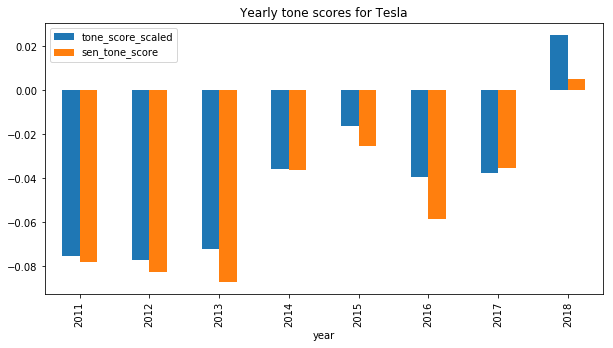

In [122]:
mda_scores_df.set_index('year')[['tone_score_scaled', 'sen_tone_score']].plot(kind='bar', 
                                                                              figsize=(10,5),
                                                                              title='Yearly tone scores for Tesla')

### Plot changes

In [123]:
mda_scores_df['sen_tone_score_lagged'] = mda_scores_df.sen_tone_score.shift(1)
mda_scores_df['sen_tone_score_delta'] = mda_scores_df['sen_tone_score'] - mda_scores_df['sen_tone_score_lagged']

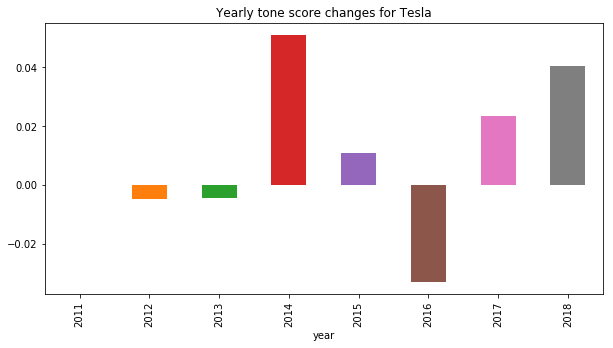

In [124]:
mda_scores_df.set_index('year')['sen_tone_score_delta'].plot(kind='bar', 
                                                             figsize=(10,5),
                                                             title='Yearly tone score changes for Tesla')